# EDA



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time
from google.colab import drive
drive.mount('/content/drive/')

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [3]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [78]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

In [4]:
train_identity = pd.read_csv(r'/content/drive/MyDrive/dataset/train_identity.csv')
train_transaction = pd.read_csv(r'/content/drive/MyDrive/dataset/train_transaction.csv')

# train_identity = pd.read_csv("C:/Users/sruth/Documents/DCU/Semester 2/CA683-DA & DM/Assignment-2/DataSet/train_identity.csv")
# train_transaction = pd.read_csv("C:/Users/sruth/Documents/DCU/Semester 2/CA683-DA & DM/Assignment-2/DataSet/train_transaction.csv")
# merge two tables
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left') 
train.shape 

(590540, 434)

In [5]:
from sklearn.utils import resample
train = resample(train,replace = False, # sample without replacement
                n_samples = 300000,
                random_state = 27)


In [6]:
train.shape

(300000, 434)

In [6]:
train['isFraud'].value_counts()

0    289426
1     10574
Name: isFraud, dtype: int64


1. TransactionDT: timedelta from a given reference datetime (not an actual timestamp)

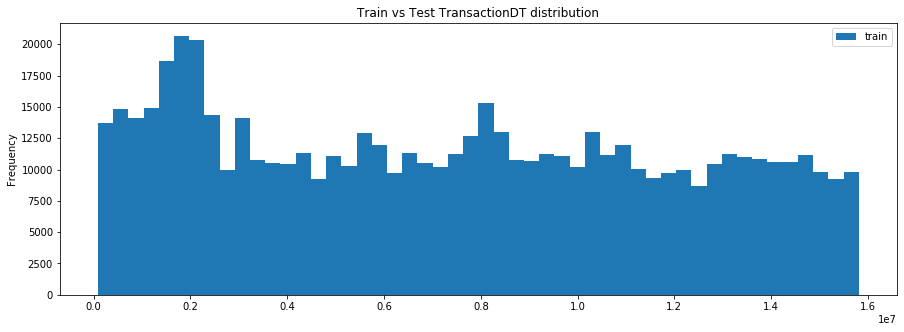

In [7]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
# test_transaction['TransactionDT'].plot(kind='hist',
#                                        label='test',
#                                        bins=50)
plt.legend()
plt.show()

In [7]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

2. TransactionAMT: transaction payment amount in USD

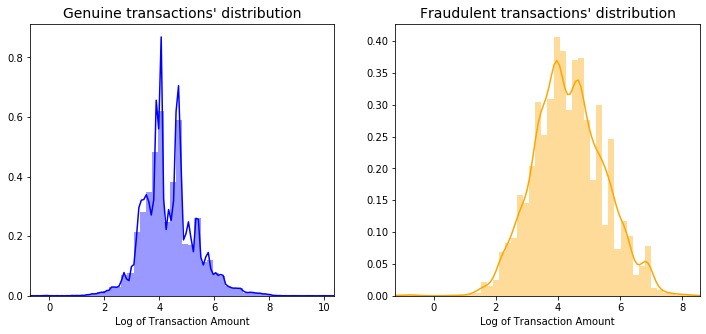

In [9]:
# Comparison of distributions of log transformed transaction amounts for fraudulent and genuine transactions:

fig, ax = plt.subplots(1,2,figsize=(12,5))

gen_trans = train.loc[train['isFraud'] == 0]['TransactionAmt'].values

sns.distplot(np.log(gen_trans),ax=ax[0],color='blue')
ax[0].set_title("Genuine transactions' distribution",fontsize=14)
ax[0].set_xlim([min(np.log(gen_trans)),max(np.log(gen_trans))])
ax[0].set_xlabel('Log of Transaction Amount')

fraud_trans = train.loc[train['isFraud'] == 1]['TransactionAmt'].values

sns.distplot(np.log(fraud_trans),ax=ax[1],color='orange')
ax[1].set_title("Fraudulent transactions' distribution",fontsize=14)
ax[1].set_xlim([min(np.log(fraud_trans)),max(np.log(fraud_trans))])
ax[1].set_xlabel('Log of Transaction Amount')

plt.show()

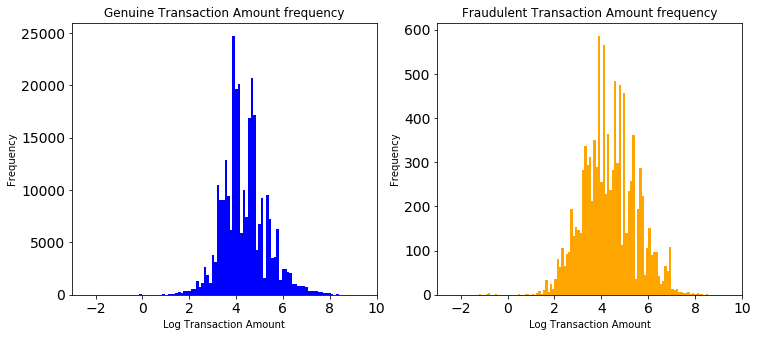

In [10]:
# Comparison of number of observations of log transformed transaction amounts for fraudulent and genuine transactions:

ffig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,5))
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Genuine Transaction Amount frequency',
          fontsize=14,
          color='blue',
          xlim=(-3, 10),
         ax=ax1)
ax1.set_xlabel('Log Transaction Amount')
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Fraudulent Transaction Amount frequency',
          fontsize=14,
          color='orange',
          xlim=(-3, 10),
         ax= ax2)
ax2.set_xlabel('Log Transaction Amount')

plt.show()



The proportion of transactions involving high transaction amounts is greater for fraudulent transactions and they have a higher average transaction amount compared to genuine transactions

In [11]:
# Let us compare the descriptives of the transaction amount for both fraud and genuine records

print(pd.concat([train[train['isFraud'] == 1]['TransactionAmt']\
                 .describe()\
                 .reset_index(), 
                 train[train['isFraud'] == 0]['TransactionAmt']\
                 .describe()\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

# We see outliers as the maximum values are much higher than the 75th percentile for both categories. 
# However, for training the model, we will retain all the records as high values for transaction amount are possible

   Fraud                No Fraud               
   index TransactionAmt    index TransactionAmt
0  count   10574.000000    count  289426.000000
1   mean     148.752979     mean     134.580085
2    std     233.483383      std     239.175182
3    min       0.292000      min       0.499000
4    25%      35.044000      25%      44.000000
5    50%      75.000000      50%      68.911000
6    75%     160.950000      75%     120.000000
7    max    5191.000000      max   31937.391000


In [12]:
# But still, let us analyse the data after removing the outliers and then calculating the different percentiles and descriptives for the transaction amount
# Considering the data to be normally distributed, most of the data lies within 3 standard deviations from the mean

data_mean, data_std = np.mean(train['TransactionAmt']), np.std(train['TransactionAmt'])
cut = data_std * 3
lower, upper = data_mean - cut, data_mean + cut

transAmt_outliers_removed = train[(train['TransactionAmt']>lower) & (train['TransactionAmt']<upper)]

In [13]:
print(pd.concat([transAmt_outliers_removed[transAmt_outliers_removed['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 transAmt_outliers_removed[transAmt_outliers_removed['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))




  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01         6.6460     0.01          9.345
1  0.10        18.6042     0.10         25.950
2  0.25        34.0000     0.25         42.950
3  0.50        70.0870     0.50         67.950
4  0.75       150.0000     0.75        117.000
5  0.90       300.0000     0.90        226.000
6  0.99       634.0856     0.99        607.734


In [14]:
print(pd.concat([transAmt_outliers_removed[transAmt_outliers_removed['isFraud'] == 1]['TransactionAmt']\
                 .describe()\
                 .reset_index(), 
                 transAmt_outliers_removed[transAmt_outliers_removed['isFraud'] == 0]['TransactionAmt']\
                 .describe()\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))




   Fraud                No Fraud               
   index TransactionAmt    index TransactionAmt
0  count   10283.000000    count  284571.000000
1   mean     119.893331     mean     110.996765
2    std     131.810373      std     117.693037
3    min       0.292000      min       0.499000
4    25%      34.000000      25%      42.950000
5    50%      70.087000      50%      67.950000
6    75%     150.000000      75%     117.000000
7    max     850.000000      max     850.950000


On comparing the data with outliers removed as shown above, we can now clearly see that from the 50th percentile, the transaction amount values for Fraud are higher than those for non-Fraud. Even the mean transaction amount is higher for Fraud transactions.

3. ProductCD: product code, the product for each transaction


In [8]:
data2 =  pd.DataFrame(train,columns=['ProductCD'])
pd.crosstab(
    train.isFraud, train.ProductCD, margins=True
)


ProductCD,C,H,R,S,W,All
isFraud,,,,,,
0,30850,16007,18372,5499,218698,289426
1,4090,815,710,375,4584,10574
All,34940,16822,19082,5874,223282,300000


Observation 
*   Product code C and W has the most fraudulent Transactions.
*   No missing data


4. card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.


 Card1-Card6:
* `Definition:` card1 - card6: Payment card information, such as card type, card category, issue bank, country, etc.  
* `Definition od Card4:` Card4 shows card distributer types. 
    * `Categories & Labels:` Visa, Mastercard, American express, Discover 
* `Definition od Card6:` Card6 shows card types. 
    * `Categories & Labels:` Debit, Credit, Debit or Credit , Charge card 

In [9]:
card_cols = [c for c in train.columns if "card" in c]
train[card_cols].head(10)

,card1,card2,card3,card4,card5,card6
219762,10057,225.0,150.0,mastercard,224.0,debit
548936,12418,514.0,150.0,mastercard,224.0,debit
278250,16972,174.0,150.0,visa,226.0,debit
195168,15651,417.0,150.0,visa,226.0,debit
160159,9500,321.0,150.0,visa,226.0,debit
151391,1675,174.0,150.0,visa,226.0,debit
221526,12544,321.0,150.0,visa,226.0,debit
108275,12695,490.0,150.0,visa,226.0,debit
551799,7826,481.0,150.0,mastercard,224.0,debit
453362,7815,161.0,150.0,mastercard,117.0,debit


In [17]:
train['card1'].isnull().sum()


0

In [18]:
train['card2'].isnull().sum()


4515

In [19]:
train['card3'].isnull().sum()


770

In [20]:
train['card4'].isnull().sum()


777

In [21]:
train['card5'].isnull().sum()


2147

In [22]:
train['card6'].isnull().sum()

773

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
def compare_with_transactionAmt(df,colname,targetname):
    # caculate aggregate stats
    df_cate = df.groupby([colname])[targetname].agg(['count', 'sum','mean'])
    df_cate.reset_index(inplace=True)
    print(df_cate)
    
    # plot visuals
    f, ax = plt.subplots(figsize=(15, 6))
    ax.tick_params(axis='x',labelrotation=90)
    plt1 = sns.lineplot(x=colname, y="mean", data=df_cate,color="r")

    for tl in ax.get_yticklabels():
        tl.set_color('r')

    ax2 = ax.twinx()
    plt2 = sns.barplot(x=colname, y="count", data=df_cate,
                       ax=ax2,alpha=0.5)
    


In [11]:



def make_card_id(df):
    cards_cols= ['card1', 'card2', 'card3','card4', 'card5','card6']
    for card in cards_cols: 
        if '1' in card: 
            df['card_id']= df[card].map(str)
        else : 
            df['card_id']+= ' '+df[card].map(str)
    return df['card_id']

In [12]:
train['card_id'] = make_card_id(train)

In [26]:
train.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_36,id_37,id_38,DeviceType,DeviceInfo,Date,_Weekdays,_Hours,_Days,card_id
219762,3206762,0,5164512,44.00,W,10057,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,2018-01-29 18:35:12,0,18,29,10057 225.0 150.0 mastercard 224.0 debit
548936,3535936,0,14497123,213.00,W,12418,514.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,2018-05-17 18:58:43,3,18,17,12418 514.0 150.0 mastercard 224.0 debit
278250,3265250,0,6782628,107.95,W,16972,174.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,2018-02-17 12:03:48,5,12,17,16972 174.0 150.0 visa 226.0 debit


In [13]:
train['card_TAmt_ratio'] = train['TransactionAmt']/train.groupby('card_id')['TransactionAmt'].transform('mean')

   isFraud   count            sum      mean
0        0  289426  287539.641826  0.993482
1        1   10574   12460.358174  1.178396


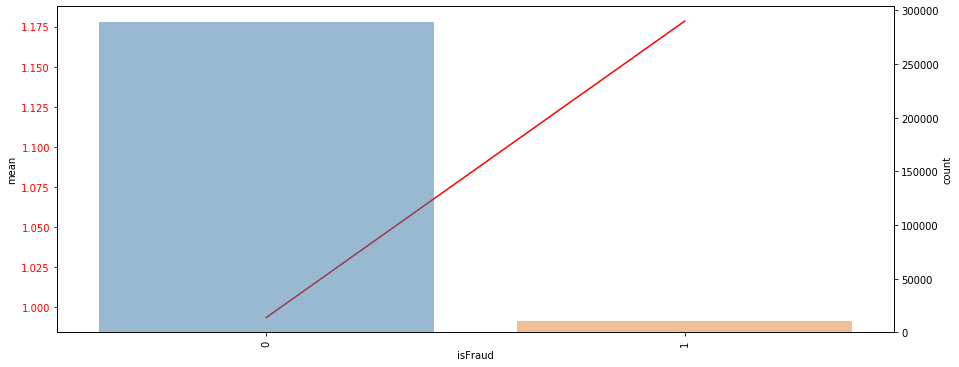

In [14]:
compare_with_transactionAmt(train,'isFraud','card_TAmt_ratio')

              card4   count   sum      mean
0  american express    4179   126  0.030151
1          discover    3375   250  0.074074
2        mastercard   96043  3328  0.034651
3              visa  195626  6852  0.035026


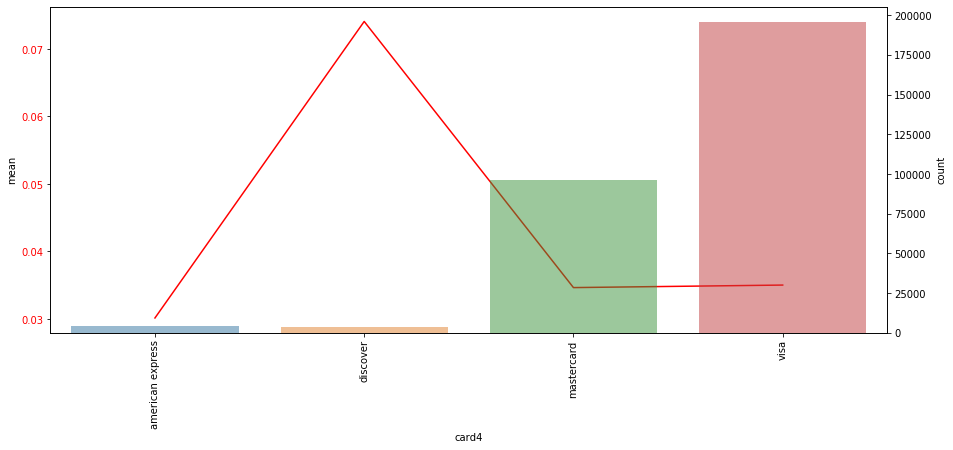

In [15]:
compare_with_transactionAmt(train,'card4','isFraud')

In [16]:
pd.crosstab(
    train.isFraud, train.card6, margins=True
).style.background_gradient(cmap="mako")

card6,charge card,credit,debit,debit or credit,All
isFraud,,,,,
0,6,70597,218056,11,288670
1,0,5069,5488,0,10557
All,6,75666,223544,11,299227


             card6   count   sum      mean
0      charge card       6     0  0.000000
1           credit   75666  5069  0.066992
2            debit  223544  5488  0.024550
3  debit or credit      11     0  0.000000


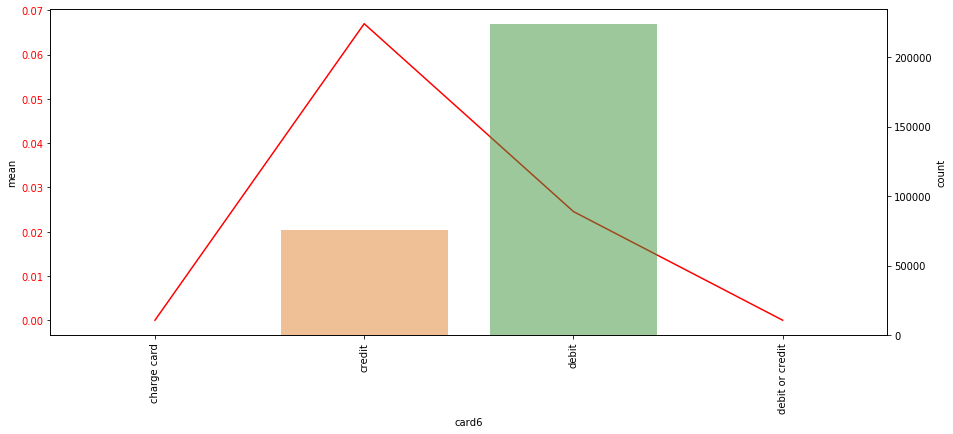

In [17]:
compare_with_transactionAmt(train,'card6','isFraud')

In [32]:
train['isFraud'].corr(train['card1'])

-0.01403287527800877

In [33]:
train['isFraud'].corr(train['card2'])

0.003645793963537925

In [34]:
train['isFraud'].corr(train['card3'])

0.15447431728448122

In [35]:
train['isFraud'].corr(train['card5'])

-0.032769579415904034

In [18]:
count_card4_type=train.card4.value_counts()

visa                195626
mastercard           96043
american express      4179
discover              3375
Name: card4, dtype: int64

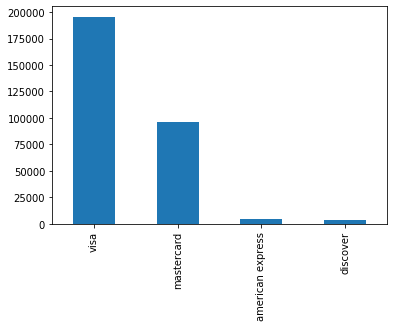

In [37]:
# For card4:
train['card4'].value_counts().plot(kind='bar')
train['card4'].value_counts()
#sns.catplot(x="card4", y="count_card4_type", data=final_table)


In [19]:
pd.crosstab(
    train.isFraud, train.card4, margins=True
).style.background_gradient(cmap="mako")

card4,american express,discover,mastercard,visa,All
isFraud,,,,,
0,4053,3125,92715,188774,288667
1,126,250,3328,6852,10556
All,4179,3375,96043,195626,299223


Data Cleaning and Pre-processing

In [39]:
train.card4.isnull().sum()

777

In [20]:
len(train['card4'].unique())
train.card4.unique()

array(['mastercard', 'visa', 'discover', 'american express', nan],
      dtype=object)

In [41]:
train.card4.value_counts()

visa                195626
mastercard           96043
american express      4179
discover              3375
Name: card4, dtype: int64

In [42]:
train['card4'].mode()

0    visa
dtype: object

In [21]:
train['card4'].fillna(train['card4'].mode()[0], inplace=True)

In [44]:
train.card4.isna().sum()

0

In [45]:
train['card6'].isna().sum()

773

In [46]:
train.card6.value_counts()

debit              223544
credit              75666
debit or credit        11
charge card             6
Name: card6, dtype: int64

In [47]:
train.card6.unique()

array(['debit', 'credit', nan, 'debit or credit', 'charge card'],
      dtype=object)

In [22]:
train['card6'].fillna('others', inplace=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x2588eeef588>,
 'caps': [<matplotlib.lines.Line2D at 0x2588eda38c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2588edf0a88>],
 'medians': [<matplotlib.lines.Line2D at 0x2588ef24548>],
 'fliers': [<matplotlib.lines.Line2D at 0x2589022d1c8>],
 'means': []}

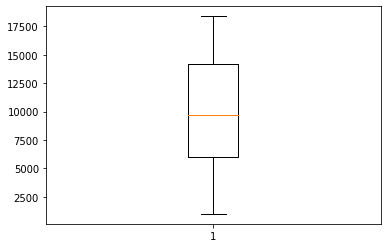

In [23]:
import matplotlib.pyplot as plt
plt.boxplot(train.card1)


In [50]:
train.card1

219762    10057
548936    12418
278250    16972
195168    15651
160159     9500
          ...  
509735     8900
168963    16435
462571    16297
75253     10737
218460     7834
Name: card1, Length: 300000, dtype: int64

In [51]:
train.isna().sum()

TransactionID      0
isFraud            0
TransactionDT      0
TransactionAmt     0
ProductCD          0
                  ..
_Weekdays          0
_Hours             0
_Days              0
card_id            0
card_TAmt_ratio    0
Length: 440, dtype: int64

In [24]:
train.drop(['card2','card3','card5'],axis=1, inplace=True)


5. addr: address
  

  Both the addresses are for the purchaser

*   addr1 is the billing region
*   addr2 is the billing country





In [53]:
train['addr1'].value_counts()

299.0    23628
325.0    21652
204.0    21275
264.0    20278
330.0    13353
         ...  
365.0        1
183.0        1
471.0        1
314.0        1
376.0        1
Name: addr1, Length: 257, dtype: int64

In [54]:
train['addr2'].value_counts()

87.0     264262
60.0       1573
96.0        339
65.0         47
32.0         45
16.0         27
31.0         24
19.0         20
26.0         12
27.0         12
59.0         10
43.0          9
69.0          9
29.0          6
98.0          6
34.0          6
71.0          5
17.0          5
102.0         5
88.0          4
52.0          4
78.0          4
57.0          4
46.0          3
54.0          3
51.0          3
62.0          3
101.0         3
10.0          3
47.0          2
24.0          2
68.0          2
36.0          2
73.0          2
20.0          2
76.0          2
72.0          2
92.0          2
30.0          2
28.0          2
13.0          2
39.0          2
70.0          1
48.0          1
66.0          1
63.0          1
38.0          1
82.0          1
21.0          1
22.0          1
89.0          1
25.0          1
97.0          1
18.0          1
100.0         1
55.0          1
61.0          1
44.0          1
93.0          1
Name: addr2, dtype: int64

In [25]:
# there are many insignificant values in the addr1 and addr2 columns that have few records, 
# so we will collectively replace their values to 'Others'

train.loc[train.addr1.isin(train.addr1.value_counts()[train.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
train.loc[train.addr2.isin(train.addr2.value_counts()[train.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

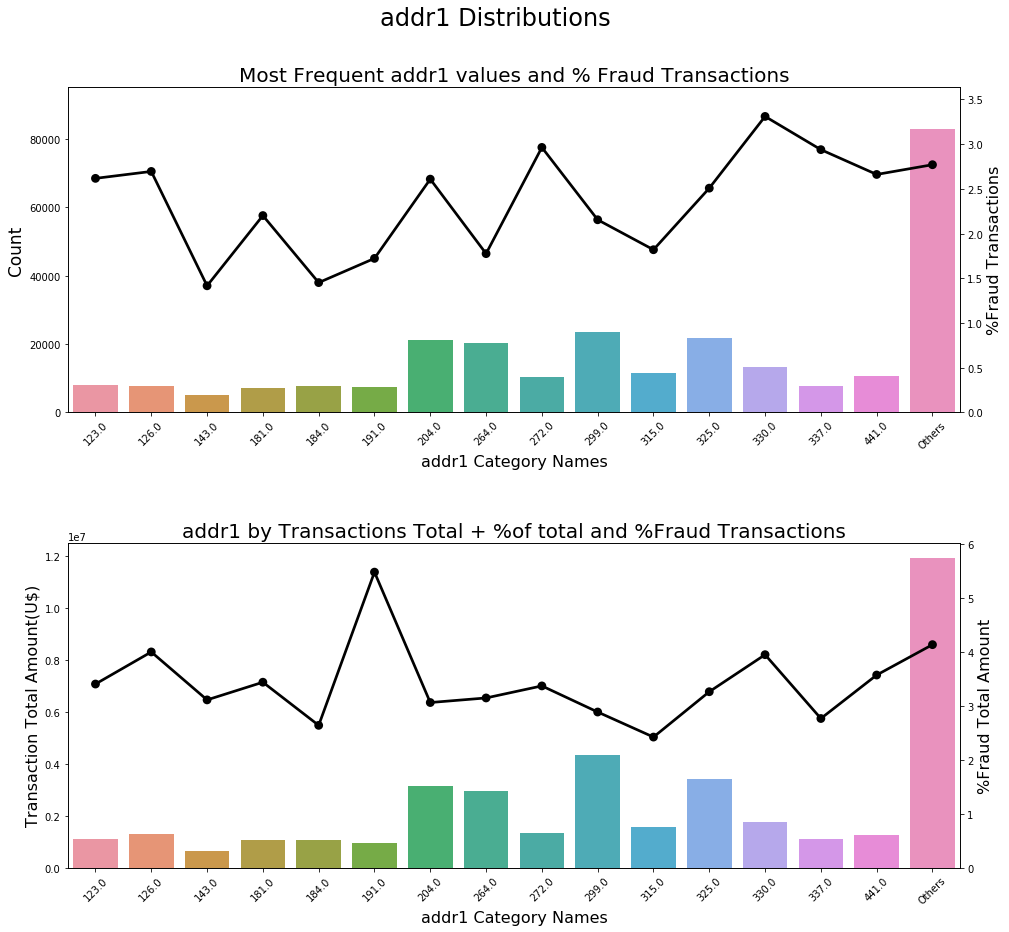

In [26]:
# For both addr1 and addr2, We will plot the percent of total transactions that are fradulent
# Also, for both addr1 and addr2, we are plotting the percent of the total transaction amount over all transactions, that is fraudulent

def fraud_proportion(df, col, lim=2000):
    ctab = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    ctab = ctab.reset_index()
    ctab.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(ctab[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=ctab, order=list(ctab[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,ctab['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(ctab[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(ctab[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    
fraud_proportion(train, 'addr1')

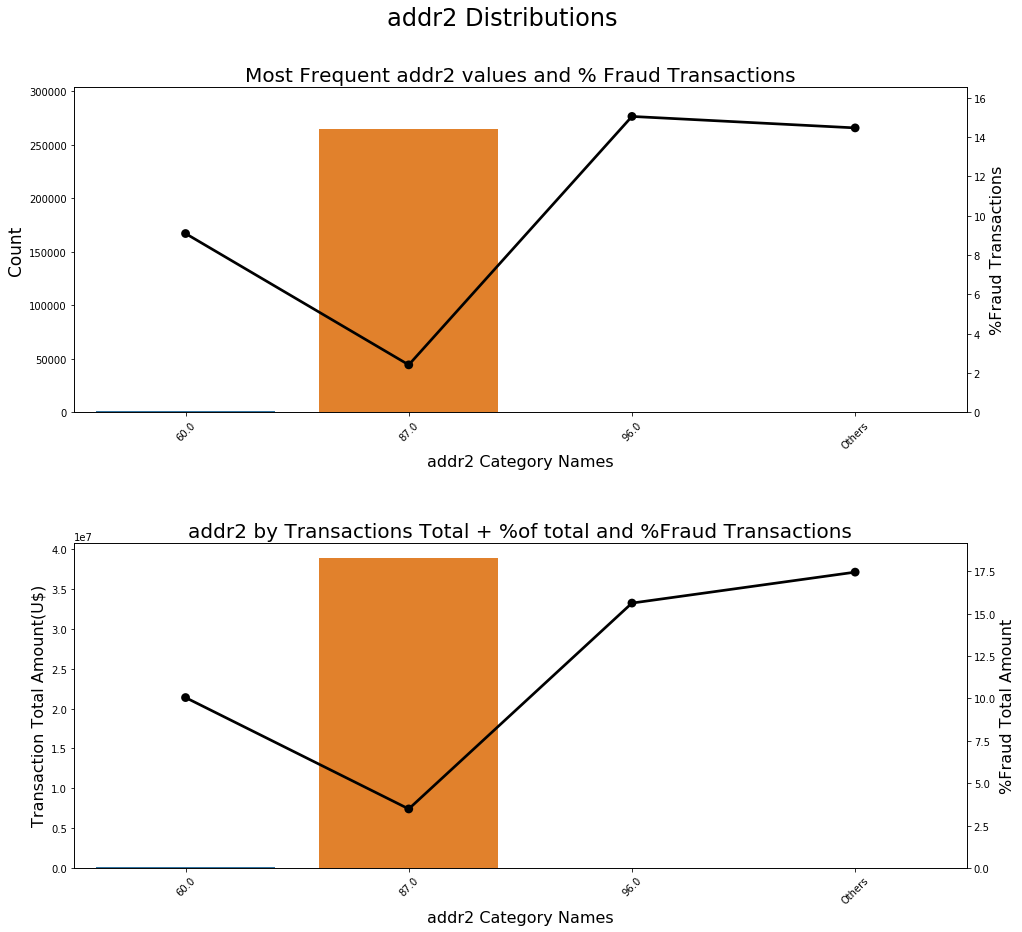

In [27]:
fraud_proportion(train, 'addr2')

More than 50% of the fraud transactions have a value of 65 in the addr2 field and almost 60% of the total transaction amount across all transactions is fraudulent for this value of addr2

D1-D15: timedelta, such as days between previous transaction

In [28]:
dcols = [c for c in train if ((c[0]=='D') & ('e' not in c))]

In [29]:
d_df =  train[dcols]

In [30]:
d_data = pd.concat([d_df,train['isFraud']],axis=1)

In [61]:
# Let us check the correlation of each of the D variables with the target variable
# We don't see any significant correlation

d_data[d_data.columns[:]].corr()['isFraud'][:]

D1        -0.066984
D2        -0.083267
D3        -0.046412
D4        -0.065859
D5        -0.064917
D6        -0.057938
D7        -0.130073
D8        -0.143999
D9        -0.043609
D10       -0.071132
D11       -0.044200
D12       -0.029231
D13       -0.058884
D14       -0.014614
D15       -0.075865
isFraud    1.000000
Name: isFraud, dtype: float64

30816

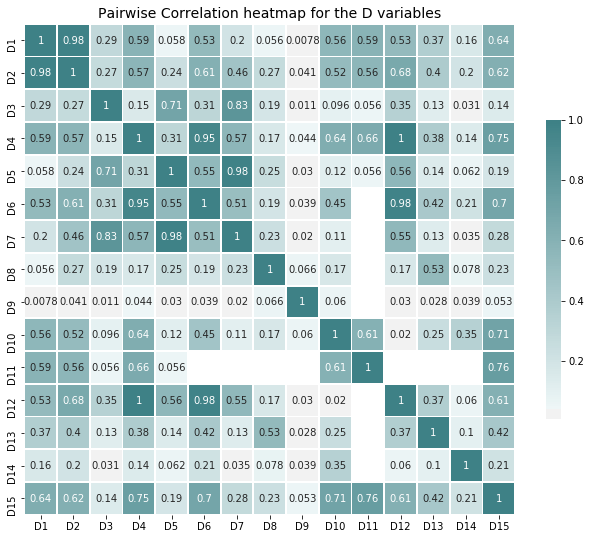

In [31]:
# Now let us check the correlation between each of the D variables

import gc

d_plot = (d_data
.filter(regex=("^D.*"))
)

d_corr = d_plot.corr(method="pearson")
fig, ax = plt.subplots(figsize=(11, 11))

cmap = sns.diverging_palette(0, 200, as_cmap=True)

sns.heatmap(d_corr, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.8, cbar_kws={"shrink": .5})
plt.title("Pairwise Correlation heatmap for the D variables", fontsize=14)

del d_plot
gc.collect()

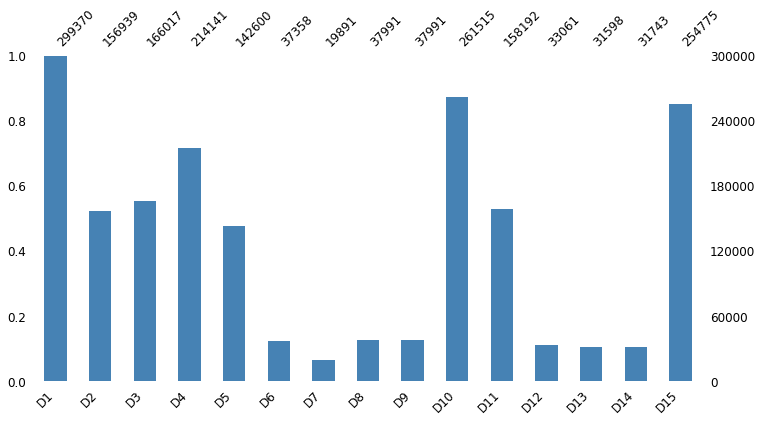

In [63]:
# Checking the number of non-null values present in each D column

import missingno as msno

msno.bar(d_df, figsize=(12, 6), fontsize=12, color='steelblue')

In [64]:
# Checking the exact number of null values in each D column

d_data.isnull().sum()/d_data.shape[0] * 100


D1          0.210000
D2         47.687000
D3         44.661000
D4         28.619667
D5         52.466667
D6         87.547333
D7         93.369667
D8         87.336333
D9         87.336333
D10        12.828333
D11        47.269333
D12        88.979667
D13        89.467333
D14        89.419000
D15        15.075000
isFraud     0.000000
dtype: float64

D1 and D2 are heavily correlated, D4 is highly correlated with D10,D11,D15, D3 and D5 are highly correlated and D15 is highly correlated with D10,D11.D10 and D11 are highly correlated

D1,D2,D3,D4,D5,D10,D11,D15 have more than 80% non-null values 


D1,D3,D4,D10,D11,D15 are the important features considering the amount of non-nulls and to avoid multicollinearity (by removing the highly correlated columns with more null values)

In [32]:
train.drop(['D2','D5','D6','D7','D8','D9','D12','D13','D14'],axis=1,inplace=True)

In [33]:
def imputing_nan(df,variables):
    
    for col in variables:
        if col[0]=='D':
            random_sample = df[col].dropna().sample(df[col].isna().sum(),random_state=1)
            random_sample.index = df[df[col].isnull()].index
            df.loc[df[col].isnull(), col] = random_sample

In [34]:
# Imputing the null values in the D columns that we retained, by random sampling (As the data is missing completely at random)

imputing_nan(train,['D1','D3','D4','D10','D11','D15'])

In [35]:
train[['D1','D3','D4','D10','D11','D15','isFraud']].head()

,D1,D3,D4,D10,D11,D15,isFraud
219762,1.0,0.0,0.0,1.0,0.0,1.0,0
548936,8.0,6.0,57.0,6.0,57.0,57.0,0
278250,182.0,7.0,4.0,182.0,191.0,191.0,0
195168,0.0,92.0,0.0,0.0,266.0,0.0,0
160159,53.0,16.0,398.0,510.0,510.0,510.0,0


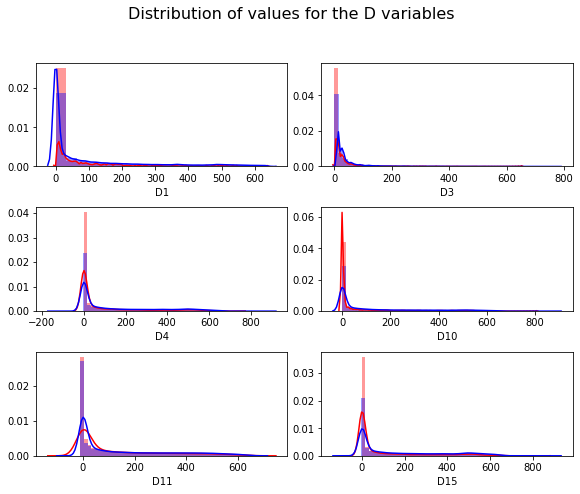

In [36]:
# We will plot the probability density functions for all D columns that we selected above
# But as seen below for all these fields, the distributions for both categories overlap hence we don't get any significant information from these
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(8,6))

plt.suptitle('Distribution of values for the D variables',size=16, y=1.12)
plt.subplots_adjust(top=0.85)

sns.distplot(train[train['isFraud']==1]['D1'].dropna(),color='red',bins=20,ax=ax1)
sns.distplot(train[train['isFraud']==0]['D1'].dropna(),color='blue',bins=20,ax=ax1)
ax1.set_xlabel('D1')

sns.distplot(train[train['isFraud']==1]['D3'].dropna(),color='red',bins=50,ax=ax2)
sns.distplot(train[train['isFraud']==0]['D3'].dropna(),color='blue',bins=50,ax=ax2)
ax2.set_xlabel('D3')

sns.distplot(train[train['isFraud']==1]['D4'].dropna(),color='red',bins=50,ax=ax3)
sns.distplot(train[train['isFraud']==0]['D4'].dropna(),color='blue',bins=50,ax=ax3)
ax3.set_xlabel('D4')

sns.distplot(train[train['isFraud']==1]['D10'].dropna(),color='red',bins=50,ax=ax4)
sns.distplot(train[train['isFraud']==0]['D10'].dropna(),color='blue',bins=50,ax=ax4)
ax4.set_xlabel('D10')

sns.distplot(train[train['isFraud']==1]['D11'].dropna(),color='red',bins=50,ax=ax5)
sns.distplot(train[train['isFraud']==0]['D11'].dropna(),color='blue',bins=50,ax=ax5)
ax5.set_xlabel('D11')

sns.distplot(train[train['isFraud']==1]['D15'].dropna(),color='red',bins=50,ax=ax6)
sns.distplot(train[train['isFraud']==0]['D15'].dropna(),color='blue',bins=50,ax=ax6)
ax6.set_xlabel('D15')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

6. dist: distance


7. P_ and (R__) emaildomain: purchaser and recipient email domain


In [37]:
train.loc[train['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

train.loc[train['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
train.loc[train['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
train.loc[train.P_emaildomain.isin(train.P_emaildomain\
                                         .value_counts()[train.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
train.P_emaildomain.fillna("NoInf", inplace=True)

In [38]:
train.loc[train['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

train.loc[train['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
train.loc[train['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
train.loc[train.R_emaildomain.isin(train.R_emaildomain\
                                         .value_counts()[train.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
train.R_emaildomain.fillna("NoInf", inplace=True)

8. C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.


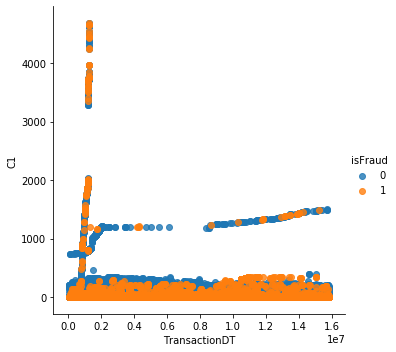

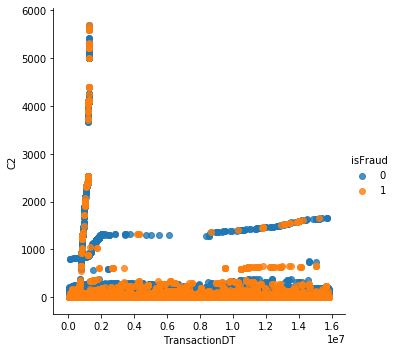

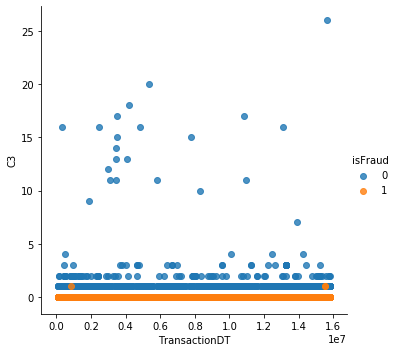

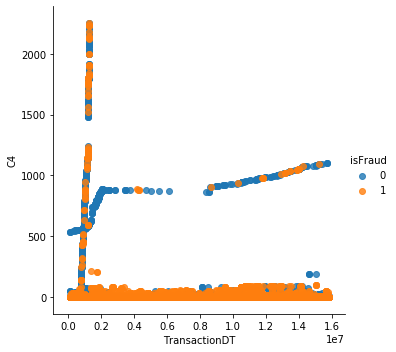

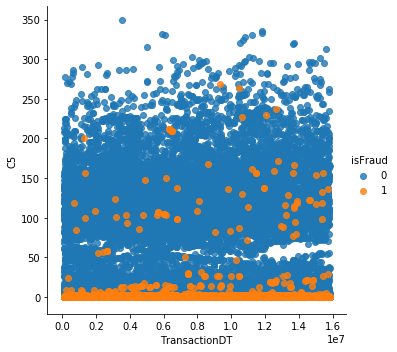

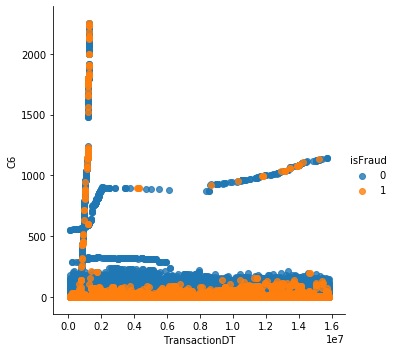

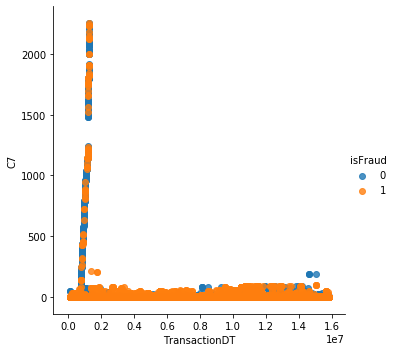

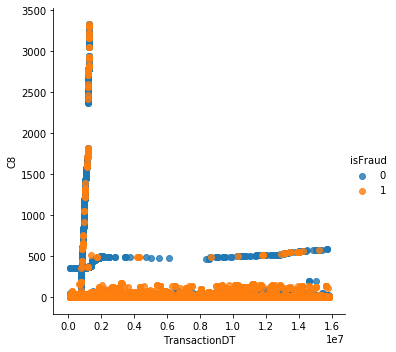

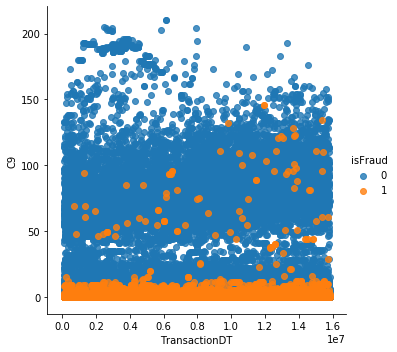

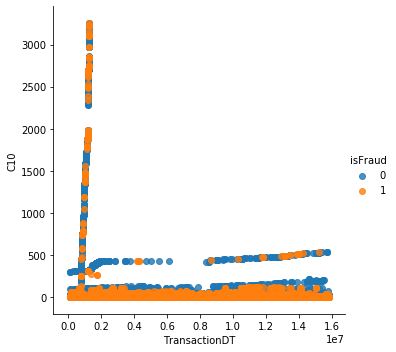

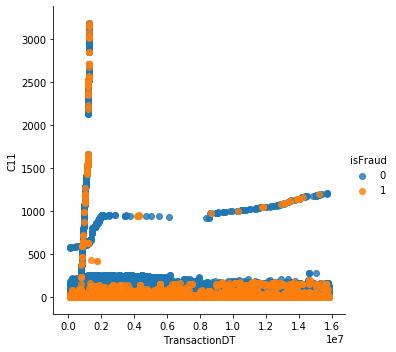

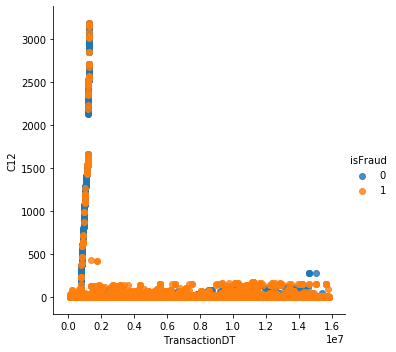

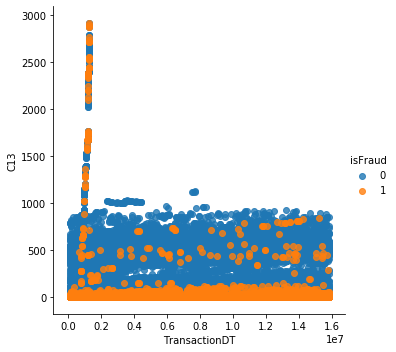

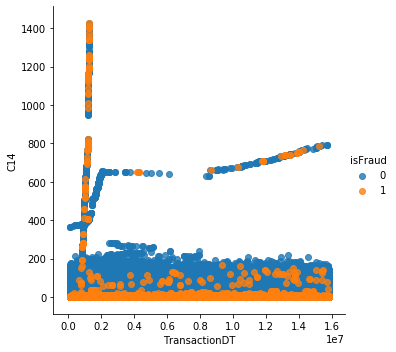

In [39]:
charts = {}
info = []
for i in range(1,15):
    info.append('C' + str(i))
for i in info:
    # feature_count = train[i].value_counts(dropna=False).reset_index().rename(columns={i: 'count', 'index': i})
    sns.lmplot(x = 'TransactionDT',y = i, data = train ,hue= 'isFraud', fit_reg=False,)
    # plt.xlim([0, 5000])
    # plt.show()                         
    


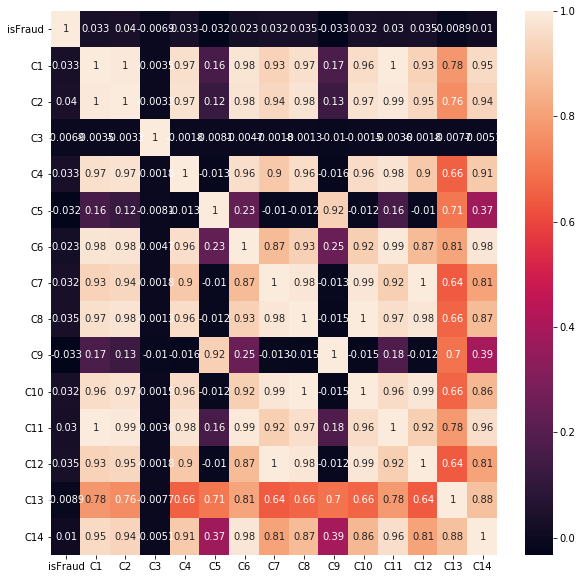

In [40]:
df = pd.DataFrame(train,columns=['isFraud','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14'])
corr1 = df.corr()
plt.subplots(figsize=(10, 10))
sns.heatmap(corr1, annot=True)


In [41]:
train.drop(['C2', 'C11', 'C7', 'C8'], axis=1,inplace=True) 


Observations 
*   There are no missing values for any of the features from C1-C14. 
*   No high corellation with the target variable.
*   C1 has high correlation with C2 and C11 hence we will consider C1 and drop C2 and C11.
*   Similarly C7 has high correltion with C12 and C8 with C10, so we will keep C7 and C8 .


M1- M9:
* `Definition:` They show match, such as names on card and address, etc.
* `Categories & Labels:` T = True, F= False, NaN values
* `Categories & Labels for M4:` M0, M1, M2

In [42]:
M_cols = [m for m in train.columns if "M" in m]
train[M_cols].head(3)

,M1,M2,M3,M4,M5,M6,M7,M8,M9
219762,T,T,T,M0,T,F,F,F,T
548936,T,T,T,M1,F,F,F,F,T
278250,T,T,T,NaN,NaN,T,F,T,T


In [76]:
train.M4.value_counts()

M0    99944
M2    30534
M1    26719
Name: M4, dtype: int64

In [43]:
#These columns have high null values with not much correlation with the targetValue
train.drop(['M1','M2','M3','M5','M6','M7','M8','M9'],axis=1,inplace=True)

11. Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

In [44]:
train.drop(['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V217',
 'V218',
 'V219',
 'V220',
 'V221',
 'V222',
 'V223',
 'V224',
 'V225',
 'V226',
 'V227',
 'V228',
 'V229',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 'V240',
 'V241',
 'V242',
 'V243',
 'V244',
 'V245',
 'V246',
 'V247',
 'V248',
 'V249',
 'V250',
 'V251',
 'V252',
 'V253',
 'V254',
 'V255',
 'V256',
 'V257',
 'V258',
 'V259',
 'V260',
 'V261',
 'V262',
 'V263',
 'V264',
 'V265',
 'V266',
 'V267',
 'V268',
 'V269',
 'V270',
 'V271',
 'V272',
 'V273',
 'V274',
 'V275',
 'V276',
 'V277',
 'V278',
 'V279',
 'V280',
 'V281',
 'V282',
 'V283',
 'V284',
 'V285',
 'V286',
 'V287',
 'V288',
 'V289',
 'V290',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V300',
 'V301',
 'V302',
 'V303',
 'V304',
 'V305',
 'V306',
 'V307',
 'V308',
 'V309',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V316',
 'V317',
 'V318',
 'V319',
 'V320',
 'V321',
 'V322',
 'V323',
 'V324',
 'V325',
 'V326',
 'V327',
 'V328',
 'V329',
 'V330',
 'V331',
 'V332',
 'V333',
 'V334',
 'V335',
 'V336',
 'V337',
 'V338',
 'V339'], axis=1,inplace=True)

In [45]:
train.shape

(300000, 77)

In [46]:
print(train.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card4', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C3', 'C4', 'C5', 'C6', 'C9', 'C10', 'C12', 'C13', 'C14', 'D1', 'D3', 'D4', 'D10', 'D11', 'D15', 'M4', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'Date', '_Weekdays', '_Hours', '_Days', 'card_id', 'card_TAmt_ratio']


In [47]:
# Label encoder
from sklearn.preprocessing import LabelEncoder
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4',
            'addr1', 'addr2','Date','card_id',
            'P_emaildomain', 'R_emaildomain']
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
          

In [48]:
X = train.drop(columns = ['isFraud'])       # input features
Y = train.isFraud  

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [50]:
Y_train.value_counts()

0    231544
1      8456
Name: isFraud, dtype: int64

In [51]:
from sklearn.utils import resample

In [52]:
train_data = pd.concat([X_train, Y_train], axis = 1)

In [53]:
not_fraud = train_data[train_data.isFraud==0]
fraud = train_data[train_data.isFraud==1]

In [54]:
fraud_upsampled = resample(fraud,
                           replace = True, # Sample with replacement
                           n_samples = len(not_fraud), # Match number in majority class
                           random_state=27)

In [55]:
upsampled = pd.concat([not_fraud, fraud_upsampled])

In [90]:
upsampled.isFraud.value_counts()

1    231544
0    231544
Name: isFraud, dtype: int64

In [56]:
lg_train = upsampled.copy()
rf_train = upsampled.copy()

In [57]:
X = lg_train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = lg_train.sort_values('TransactionDT')['isFraud']

In [82]:
from sklearn.model_selection import TimeSeriesSplit,KFold

n_fold = 3
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=3)

In [83]:
def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, 
                               plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, 
                               averaging='usual', n_jobs=-1):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
#         if model_type == 'xgb':
#             train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
#             valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

#             watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
#             model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
#             y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
#             y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
#         if model_type == 'sklearn':
#             model = model
#             model.fit(X_train, y_train)
            
#             y_pred_valid = model.predict(X_valid).reshape(-1,)
#             score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
#             print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
#             print('')
            
#             y_pred = model.predict_proba(X_test)
        
#         if model_type == 'cat':
#             model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
#                                       loss_function=Logloss)
#             model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

#             y_pred_valid = model.predict(X_valid)
#             y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict


In [60]:
def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True

In [62]:
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


In [ ]:
lg_mdl = lgb.LGBMClassifier(random_state=42)

In [ ]:
param_space = {
        'num_leaves' : [70,80,127,256,380]
        }

In [ ]:
CV_lgb = GridSearchCV(estimator=lg_mdl, param_grid=param_space, cv=3)
CV_lgb.fit(X, y)

In [ ]:
CV_.best_params_

In [ ]:
param_space = {
         'max_depth': [10,12,13,15],
        'num_leaves' : [70,80,127,256,380]
          }

In [ ]:
CV_lgb = GridSearchCV(estimator=lg_mdl, param_grid=param_space, cv=3)
CV_lgb.fit(X, y)

In [ ]:
CV_.best_params_

In [ ]:
param_grid={'learning_rate': [0.02, 0.03, 0.05],
                         'max_depth': [10, 12, 13, 15],
                         'num_leaves': [70, 256, 380]}
               # 'boosting_type' : ['gbdt','goss']}

In [ ]:
CV_lgb = GridSearchCV(estimator=lg_mdl, param_grid=param_space, cv=3)
CV_lgb.fit(X, y)

In [ ]:
CV_.best_params_

Fold 1 started at Fri Apr 16 09:10:42 2021
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.999828	training's auc: 0.999828	valid_1's auc: 0.882323	valid_1's auc: 0.882323
Early stopping, best iteration is:
[354]	training's auc: 0.998875	training's auc: 0.998875	valid_1's auc: 0.884921	valid_1's auc: 0.884921
Fold 2 started at Fri Apr 16 09:38:27 2021
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[194]	training's auc: 0.993575	training's auc: 0.993575	valid_1's auc: 0.896569	valid_1's auc: 0.896569
Fold 3 started at Fri Apr 16 09:58:57 2021
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[249]	training's auc: 0.996731	training's auc: 0.996731	valid_1's auc: 0.886711	valid_1's auc: 0.886711
Fold 4 started at Fri Apr 16 10:22:06 2021
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[276]	training's auc: 0.

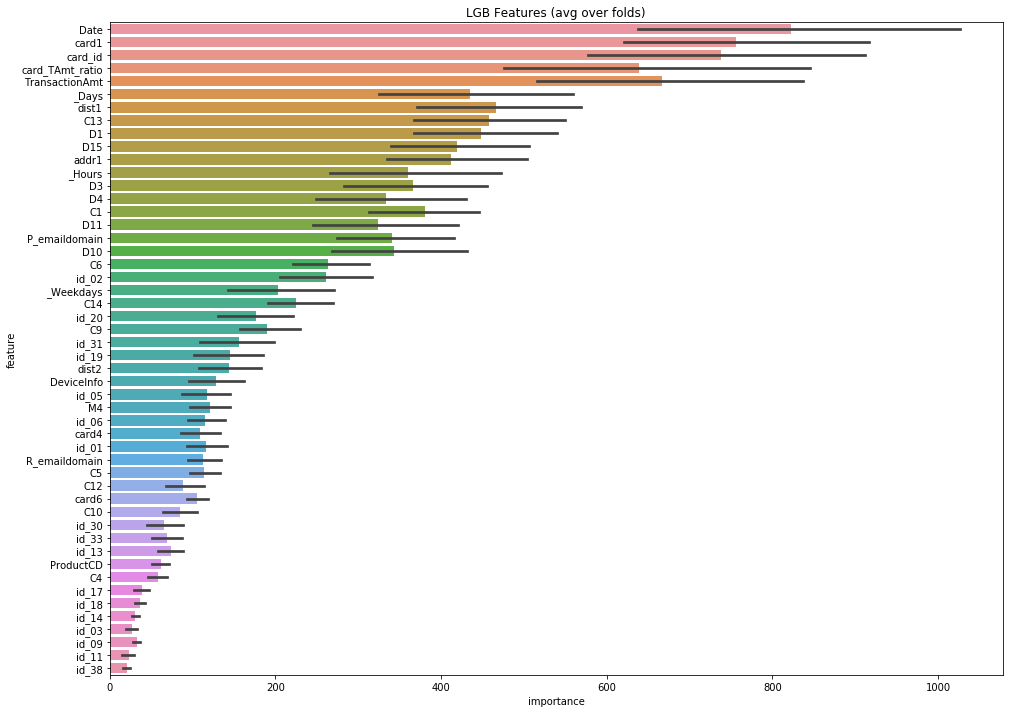

In [63]:
################################## The model run with parameters after Hyper-tuning #######################

params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
         'max_depth': 15,
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

In [ ]:
# lg_pred=.predict(X_test)

In [67]:

X_test['isFraud'] = result_dict_lgb['prediction'] # This adds column 'isFraud' to the X test dataset, 
                                                   # so we may have to drop this column for re-using it 




In [68]:
# X_test.to_csv('/content/drive/MyDrive/dataset/submission.csv', index=False)

X_test['isFraud'].head()

80411     0.076897
46372     0.098575
197950    0.097270
228264    0.280564
100637    0.570732
Name: isFraud, dtype: float64

In [69]:
X_test['y_pred'] = (X_test.isFraud >= 0.5).astype('int')

In [72]:
y_pred_lg = X_test['y_pred']
y_pred_prob_lg = X_test.isFraud

In [73]:
p_lg = precision_score(Y_test, y_pred_lg, average='macro')
r_lg = recall_score(Y_test, y_pred_lg, average='macro')
f1score_lg = f1_score(Y_test, y_pred_lg, average='macro')
 
print('precision_score: %s'% p_lg)
print('recall_score: %s'% r_lg)
print('f1_score: %s'% f1score_lg)
print()
print(classification_report(Y_test, y_pred_lg))

precision_score: 0.713911565867764
recall_score: 0.8509608735090919
f1_score: 0.7633456299387398

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     57882
           1       0.44      0.74      0.55      2118

    accuracy                           0.96     60000
   macro avg       0.71      0.85      0.76     60000
weighted avg       0.97      0.96      0.96     60000



######################### C14 #########################
ROC_AUC_score : 0.850961
[[55878  2004]
 [  558  1560]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     57882
           1       0.44      0.74      0.55      2118

    accuracy                           0.96     60000
   macro avg       0.71      0.85      0.76     60000
weighted avg       0.97      0.96      0.96     60000



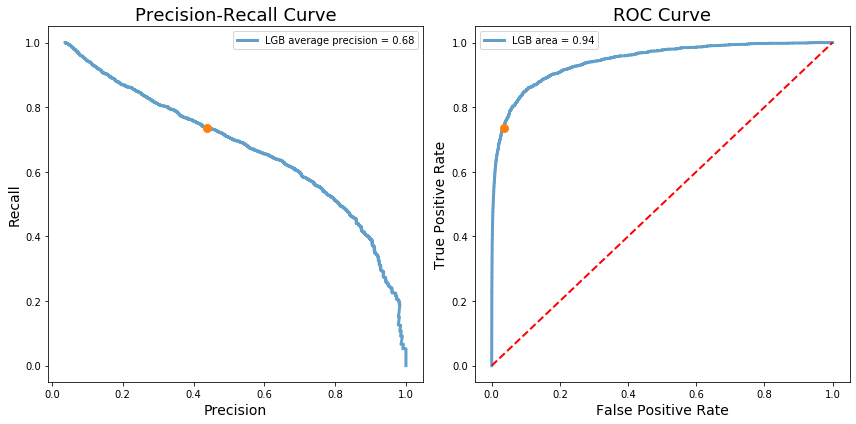

In [81]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))
   
print("ROC_AUC_score : %.6f" % (roc_auc_score(Y_test, y_pred_lg)))
#Confusion Matrix
print(confusion_matrix(Y_test, y_pred_lg))
print("-"*15,"CLASSIFICATION REPORT","-"*15)
print(classification_report(Y_test, y_pred_lg))

#precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_test, y_pred_prob_lg)
avg_pre = average_precision_score(Y_test, y_pred_prob_lg)
ax1.plot(precision, recall, label = "LGB" + " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
ax1.set_xlabel('Recall', fontsize = 14)
ax1.set_ylabel('Precision', fontsize = 14)
ax1.set_title('Precision-Recall Curve', fontsize = 18)
ax1.legend(loc = 'best')
#find default threshold
close_default = np.argmin(np.abs(thresholds_pr - 0.5))
ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

#roc-curve
fpr, tpr, thresholds_roc = roc_curve(Y_test, y_pred_prob_lg)
roc_auc = auc(fpr,tpr)
ax2.plot(fpr,tpr, label = "LGB" + " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
ax2.set_xlabel("False Positive Rate", fontsize = 14)
ax2.set_ylabel("True Positive Rate", fontsize = 14)
ax2.set_title("ROC Curve", fontsize = 18)
ax2.legend(loc = 'best')
#find default threshold
close_default = np.argmin(np.abs(thresholds_roc - 0.5))
ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
plt.tight_layout()
plt.show()

In [ ]:
##################################################################################################

############################### Implementation of Random Forest ##########################

In [121]:
rf_missing = rf_train[rf_train.columns[rf_train.isna().any()]]


In [136]:
print(rf_missing.columns.tolist())

['dist1', 'dist2', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11']


In [122]:
rf_missing.isnull().sum()/rf_missing.shape[0] * 100

dist1    67.853626
dist2    87.954773
id_01    60.883245
id_02    61.362851
id_03    77.576184
id_04    77.576184
id_05    62.289457
id_06    62.289457
id_07    98.493591
id_08    98.493591
id_09    75.131940
id_10    75.131940
id_11    61.352702
dtype: float64

In [131]:
rf_train.drop(['dist2','id_07','id_08'],axis=1,inplace=True)

In [132]:
rf_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card4,card6,addr1,addr2,dist1,...,id_38,DeviceType,DeviceInfo,Date,_Weekdays,_Hours,_Days,card_id,card_TAmt_ratio,isFraud
513721,3500721,13452875,295.00,4,12695,3,2,11,1,6.0,...,2,2,1458,257118,5,16,5,2105,2.054643,0
477267,3464267,12352054,186.00,4,14858,3,2,11,1,NaN,...,2,2,1458,238904,6,23,22,3763,1.522249,0
331520,3318520,8143958,59.00,4,9500,3,2,8,1,NaN,...,2,2,1458,165643,0,6,5,11813,0.500656,0
382166,3369166,9573259,347.31,4,18190,2,1,15,1,NaN,...,2,2,1458,191002,2,19,21,6330,1.948164,0
582089,3569089,15544253,77.00,4,15576,3,2,15,1,432.0,...,2,2,1458,291436,1,21,29,4330,0.230779,0


In [146]:
def replacing_nan(df,variables):
    
    for col in variables:
        
            random_sample = df[col].dropna().sample(df[col].isna().sum(),random_state=1,replace=True)
            random_sample.index = df[df[col].isnull()].index
            df.loc[df[col].isnull(), col] = random_sample

In [147]:
replacing_nan(rf_train,['dist1', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11'])

In [151]:
print(rf_train[rf_train.columns[rf_train.isna().any()]].columns.tolist())

[]


In [152]:
rf_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card4,card6,addr1,addr2,dist1,...,id_38,DeviceType,DeviceInfo,Date,_Weekdays,_Hours,_Days,card_id,card_TAmt_ratio,isFraud
513721,3500721,13452875,295.00,4,12695,3,2,11,1,6.0,...,2,2,1458,257118,5,16,5,2105,2.054643,0
477267,3464267,12352054,186.00,4,14858,3,2,11,1,1.0,...,2,2,1458,238904,6,23,22,3763,1.522249,0
331520,3318520,8143958,59.00,4,9500,3,2,8,1,137.0,...,2,2,1458,165643,0,6,5,11813,0.500656,0
382166,3369166,9573259,347.31,4,18190,2,1,15,1,18.0,...,2,2,1458,191002,2,19,21,6330,1.948164,0
582089,3569089,15544253,77.00,4,15576,3,2,15,1,432.0,...,2,2,1458,291436,1,21,29,4330,0.230779,0


In [153]:
x_train = rf_train.drop(columns = ['isFraud'])       # input features
y_train = rf_train.isFraud 

In [161]:
test_missing = X_test[X_test.columns[X_test.isna().any()]]

In [163]:
print(test_missing.columns.tolist())

['dist1', 'dist2', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11']


In [164]:
X_test.drop(['dist2','id_07','id_08'],axis=1,inplace=True)

In [165]:
replacing_nan(X_test,['dist1', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11'])

In [166]:
X_test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card4,card6,addr1,addr2,dist1,...,id_38,DeviceType,DeviceInfo,Date,_Weekdays,_Hours,_Days,card_id,card_TAmt_ratio,isFraud
80411,3067411,1728877,100.000,2,3682,3,1,15,1,5.0,...,0,0,592,40382,3,0,21,7776,0.590422,0.001763
46372,3033372,1108629,32.860,0,3154,2,2,15,0,2.0,...,1,0,1458,23326,2,19,13,7407,0.918677,0.009171
197950,3184950,4477055,117.000,4,9500,3,2,1,1,4.0,...,2,2,1458,98900,6,19,21,11813,0.992827,0.010994
228264,3215264,5414969,43.261,0,3089,3,1,16,4,25.0,...,0,1,851,114156,3,16,1,7360,1.230502,0.016907
100637,3087637,2039689,150.000,2,2631,2,2,10,1,42.0,...,0,0,1342,50323,6,14,24,7035,1.052262,0.035426


In [171]:
print(X_test.columns.tolist())

['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card4', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C3', 'C4', 'C5', 'C6', 'C9', 'C10', 'C12', 'C13', 'C14', 'D1', 'D3', 'D4', 'D10', 'D11', 'D15', 'M4', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'Date', '_Weekdays', '_Hours', '_Days', 'card_id', 'card_TAmt_ratio', 'isFraud']


In [173]:
print(X_train.columns.tolist())

['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card4', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C3', 'C4', 'C5', 'C6', 'C9', 'C10', 'C12', 'C13', 'C14', 'D1', 'D3', 'D4', 'D10', 'D11', 'D15', 'M4', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'Date', '_Weekdays', '_Hours', '_Days', 'card_id', 'card_TAmt_ratio']


In [174]:
X_test.drop('isFraud',axis=1,inplace=True)

In [179]:
###################################################################################################################
# Testing different parameters for RF

# params = {'n_estimators': [50,200,300,400,500,600,700] }
# params = {'max_depth': [5,10,15,20,25]}
# params = {'max_features': [2,4,6,8,10]}

# After checking each parameter one at a time and evaluating the model, we decide the below list of possible parameters,
# we then check the parameters further
param_grid = { 
    'n_estimators': [20, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [2,4,6],
    'criterion' :['gini', 'entropy']
}

In [ ]:
rfc=RandomForestClassifier(random_state=42)

In [180]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 4, 6],
                         'n_estimators': [20, 50]})

In [181]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'n_estimators': 50}

In [189]:
# give n_job=-1 to use all the processors of you computer else best is to give -2 so that all the processors
# but one will be used for this task and you will have 1 processor free to do other tasks

trfc = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 50, min_samples_leaf=2, criterion= 'entropy',n_jobs=-1)

In [191]:
trfc.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=2, n_estimators=50,
                       random_state=42)

In [192]:
y_pred_rf=trfc.predict(X_test)

In [193]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(Y_test,pred2))

Accuracy for Random Forest on CV data:  0.9822


In [194]:
y_pred_pro_rf = trfc.predict_proba(X_test)
y_scores_rf = pd.DataFrame(y_pred_pro_rf, columns=trfc.classes_.tolist())[1].values

In [201]:
# precision, recall, f1 score after using tuned hyperparameters using CVGridSearch parameters, for our random forest
p_rf = precision_score(Y_test, pred2, average='macro')
r2 = recall_score(Y_test, pred2, average='macro')
f1score_2 = f1_score(Y_test, pred2, average='macro')
 
print('precision_score: %s'% p2)
print('recall_score: %s'% r2)
print('f1_score: %s'% f1score_2)
print()
print(classification_report(Y_test, pred2))

precision_score: 0.955094062426076
recall_score: 0.7683443692662604
f1_score: 0.835924073772961

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     57882
           1       0.93      0.54      0.68      2118

    accuracy                           0.98     60000
   macro avg       0.96      0.77      0.84     60000
weighted avg       0.98      0.98      0.98     60000



In [ ]:
p_rf = precision_score(Y_test, y_pred_rf, average='macro')
r_rf = recall_score(Y_test, y_pred_rf, average='macro')
f1score_rf = f1_score(Y_test, y_pred_rf, average='macro')
 
print('precision_score: %s'% p_rf)
print('recall_score: %s'% r_rf)
print('f1_score: %s'% f1score_rf)
print()
print(classification_report(Y_test, y_pred_rf))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))
   
print("ROC_AUC_score : %.6f" % (roc_auc_score(Y_test, y_pred_lg)))
#Confusion Matrix
print(confusion_matrix(Y_test, y_pred_lg))
print("-"*15,"CLASSIFICATION REPORT","-"*15)
print(classification_report(Y_test, y_pred_lg))

#precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_test, y_pred_prob_lg)
avg_pre = average_precision_score(Y_test, y_pred_prob_lg)
ax1.plot(precision, recall, label = "LGB" + " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
ax1.set_xlabel('Recall', fontsize = 14)
ax1.set_ylabel('Precision', fontsize = 14)
ax1.set_title('Precision-Recall Curve', fontsize = 18)
ax1.legend(loc = 'best')
#find default threshold
close_default = np.argmin(np.abs(thresholds_pr - 0.5))
ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

#roc-curve
fpr, tpr, thresholds_roc = roc_curve(Y_test, y_pred_prob_lg)
roc_auc = auc(fpr,tpr)
ax2.plot(fpr,tpr, label = "LGB" + " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
ax2.set_xlabel("False Positive Rate", fontsize = 14)
ax2.set_ylabel("True Positive Rate", fontsize = 14)
ax2.set_title("ROC Curve", fontsize = 18)
ax2.legend(loc = 'best')
#find default threshold
close_default = np.argmin(np.abs(thresholds_roc - 0.5))
ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
plt.tight_layout()
plt.show()